# Here is my notebook of a sample chess game using a 8x3 board. Each player is given 6 pieces across the left end/strip of the board. We will set the computer to the first player(white). The minmax recursive function will use a basic evalutation function, adding to the computers score for its pieces, and subtracting for blacks.

In [1]:
# pip install python-chess

In [2]:
import chess
import numpy as np
import random
import functools
import math
import time
from datetime import datetime
import matplotlib.pyplot as plt

random.seed(42)

In [3]:
s = datetime.now()
e = datetime.now()

delta = e - s
print(delta)


0:00:00


In [4]:
# Create an empty board
board = chess.Board(None)  # no pieces

# Place 3 white pieces on the first row
board.set_piece_at(chess.A2, chess.Piece(chess.PAWN, chess.WHITE))
board.set_piece_at(chess.B2, chess.Piece(chess.PAWN, chess.WHITE))
board.set_piece_at(chess.C2, chess.Piece(chess.PAWN, chess.WHITE))

# Place 3 black pieces on the first row
board.set_piece_at(chess.A7, chess.Piece(chess.PAWN, chess.BLACK))
board.set_piece_at(chess.B7, chess.Piece(chess.PAWN, chess.BLACK))
board.set_piece_at(chess.C7, chess.Piece(chess.PAWN, chess.BLACK))


# Three offesnsive pieces white
board.set_piece_at(chess.A1, chess.Piece(chess.QUEEN, chess.WHITE))
board.set_piece_at(chess.B1, chess.Piece(chess.KING, chess.WHITE))
board.set_piece_at(chess.C1, chess.Piece(chess.ROOK, chess.WHITE))

# Three offesnive pieces black
board.set_piece_at(chess.A8, chess.Piece(chess.QUEEN, chess.BLACK))
board.set_piece_at(chess.B8, chess.Piece(chess.KING, chess.BLACK))
board.set_piece_at(chess.C8, chess.Piece(chess.ROOK, chess.BLACK))

8 Row 3 Column Board


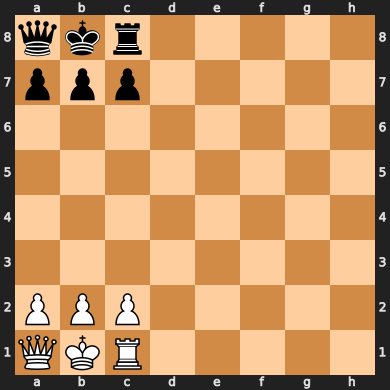

In [5]:
print("8 Row 3 Column Board")
display(board)

In [6]:
board.piece_map().items()

dict_items([(58, Piece.from_symbol('r')), (57, Piece.from_symbol('k')), (56, Piece.from_symbol('q')), (50, Piece.from_symbol('p')), (49, Piece.from_symbol('p')), (48, Piece.from_symbol('p')), (10, Piece.from_symbol('P')), (9, Piece.from_symbol('P')), (8, Piece.from_symbol('P')), (2, Piece.from_symbol('R')), (1, Piece.from_symbol('K')), (0, Piece.from_symbol('Q'))])

<p align="center">

$$
\text{UCB1} = \text{win\_rate} + C \sqrt{\frac{\ln N_{\text{parent}}}{N_{\text{child}}}}
$$

</p>


## We will utilze both a Monte Carlo Tree Search for evaluation, and a min max algorthm to search through different boards. The above equation is the one the MCTS uses during the selection phase

1. Selection
2. Expansion
3. Rollout
4. Backprop

In [7]:
# ---------- MCTS Node Class ----------
class MCTSNode:
    def __init__(self, board, parent=None, move=None):
        self.board = board          # current chess position
        self.parent = parent        # reference to parent node
        self.move = move            # move that led here
        self.children = []          # list of child nodes
        self.visits = 0             # number of times visited
        self.wins = 0.0             # total reward (sum of playout results)
        self.untried_moves = [m for m in board.legal_moves if is_valid_move(m)]

    def ucb1(self, exploration=1.4):
        """UCB1 (Upper Confidence Bound) — balance exploration vs exploitation."""
        if self.visits == 0:
            return float("inf")
        return (self.wins / self.visits) + exploration * math.sqrt(math.log(self.parent.visits + 1) / self.visits)

    def best_child(self, exploration=1.4):
        """Pick the child with the best UCB1 score."""
        return max(self.children, key=lambda c: c.ucb1(exploration))

    def expand(self):
        """Create and return a new child node for one untried move."""
        move = self.untried_moves.pop()
        next_board = self.board.copy()
        next_board.push(move)
        child_node = MCTSNode(next_board, parent=self, move=move)
        self.children.append(child_node)
        return child_node

    def backpropagate(self, result):
        """Update stats (wins and visits) recursively up to the root."""
        self.visits += 1
        self.wins += result
        if self.parent:
            self.parent.backpropagate(1 - result)  # invert result for opponent

    def is_fully_expanded(self):
        return len(self.untried_moves) == 0

    def is_terminal(self):
        return self.board.is_game_over()


# Helper functions
valid_squares = {chess.square(file, rank) for file in range(0, 3) for rank in range(0, 8)}
def is_valid_move(move):
    return move.from_square in valid_squares and move.to_square in valid_squares

In [8]:
def plot_mcts_stats(wins, visits, win_rate_history=None, depths=None):
    """
    Visualize MCTS statistics:
       Win rate per move
       Visits per move
       Win rate over iterations (optional)
       Distribution of simulation depths (optional)
    """

    moves = [m.uci() for m in wins.keys()]
    win_rates = [wins[m] / (visits[m] + 1e-6) for m in wins.keys()]
    visit_counts = [visits[m] for m in wins.keys()]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle("Monte Carlo Tree Search (MCTS) Insights", fontsize=14, weight="bold")

    # Win rate per move
    axes[0, 0].bar(moves, win_rates, color='skyblue')
    axes[0, 0].set_title("Estimated Win Rate per Move")
    axes[0, 0].set_ylabel("Win Rate")
    axes[0, 0].set_xlabel("Move")

    # Visits per move
    axes[0, 1].bar(moves, visit_counts, color='salmon')
    axes[0, 1].set_title("Number of Simulations per Move")
    axes[0, 1].set_ylabel("Visits")
    axes[0, 1].set_xlabel("Move")

    # Win rate evolution (if data provided)
    if win_rate_history:
        axes[1, 0].plot(
            range(1, len(win_rate_history) + 1),
            win_rate_history,
            color='green',
            marker='o',
            linewidth=2
        )
        axes[1, 0].set_title("Best Move Win Rate Over Iterations")
        axes[1, 0].set_xlabel("Iteration Blocks")
        axes[1, 0].set_ylabel("Best Move Win Rate")
    else:
        axes[1, 0].text(0.5, 0.5, "No Win Rate History Data", ha="center", va="center")
        axes[1, 0].set_axis_off()

    # Simulation depth histogram (if provided)
    if depths:
        axes[1, 1].hist(depths, bins=15, color='purple', alpha=0.7)
        axes[1, 1].set_title("Distribution of Simulation Lengths")
        axes[1, 1].set_xlabel("Moves per Simulation")
        axes[1, 1].set_ylabel("Frequency")
    else:
        axes[1, 1].text(0.5, 0.5, "No Depth Data", ha="center", va="center")
        axes[1, 1].set_axis_off()

    plt.tight_layout()
    plt.show()

In [9]:
# ---------- Simulation Phase ----------
def random_playout(board):
    """Play random moves until game ends."""
    sim_board = board.copy()
    while not sim_board.is_game_over():
        legal_moves = [m for m in sim_board.legal_moves if is_valid_move(m)]
        if not legal_moves:
            break
        sim_board.push(random.choice(legal_moves))
    result = sim_board.result()
    if result == "1-0":
        return 1
    elif result == "0-1":
        return 0
    else:
        return 0.5


# ---------- Main MCTS Algorithm ----------
# def mcts_move(board, iterations=500):
#     """Return the best move using Monte Carlo Tree Search."""
#     root = MCTSNode(board)

#     for _ in range(iterations):
#         node = root

#         # 1. SELECTION
#         while not node.is_terminal() and node.is_fully_expanded():
#             node = node.best_child()

#         # 2. EXPANSION
#         if not node.is_terminal() and node.untried_moves:
#             node = node.expand()

#         # 3. SIMULATION
#         result = random_playout(node.board)

#         # 4. BACKPROPAGATION
#         node.backpropagate(result)

#     # pick the child with the best win rate
#     best_child = max(root.children, key=lambda c: c.wins / (c.visits + 1e-6))
#     print(f"MCTS chooses move: {best_child.move}, win rate: {best_child.wins / best_child.visits:.2f}")
#     return best_child.move

def mcts_move(board, simulations):
    legal_moves = [m for m in board.legal_moves if is_valid_move(m)]
    if not legal_moves:
        return None

    wins = {move: 0 for move in legal_moves}
    visits = {move: 0 for move in legal_moves}

    win_rate_history = []
    depths = []

    for i in range(simulations):
        move = random.choice(legal_moves)
        temp_board = board.copy()
        temp_board.push(move)

        # Simulate random game
        depth = 0
        while not temp_board.is_game_over() and depth < 100:
            legal_moves_temp = [m for m in temp_board.legal_moves if is_valid_move(m)]
            if not legal_moves_temp:
                break
            temp_board.push(random.choice(legal_moves_temp))
            depth += 1
        depths.append(depth)

        result = temp_board.result()
        if result == "1-0":
            outcome = 1
        elif result == "0-1":
            outcome = 0
        else:
            outcome = 0.5

        if board.turn == chess.WHITE:
            wins[move] += outcome
        else:
            wins[move] += (1 - outcome)
        visits[move] += 1

        # Track progress every 50 simulations
        if (i + 1) % 50 == 0:
            best_move = max(wins, key=lambda m: wins[m] / (visits[m] + 1e-6))
            win_rate_history.append(wins[best_move] / (visits[best_move] + 1e-6))

    # Visualization
    plot_mcts_stats(wins, visits, win_rate_history, depths)

    # Choose final best move
    move_scores = {m: wins[m] / (visits[m] + 1e-6) for m in legal_moves}
    best_move = max(move_scores, key=move_scores.get)
    print(f"The best move is: {best_move}, with score: {move_scores[best_move]}")
    return best_move

Current board:


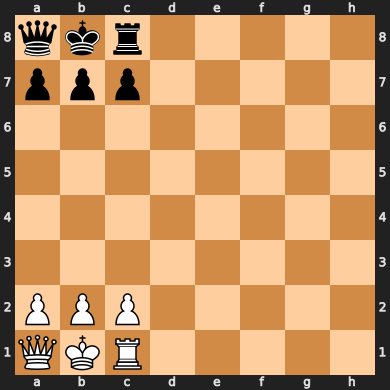

Computer (MCTS) thinking...


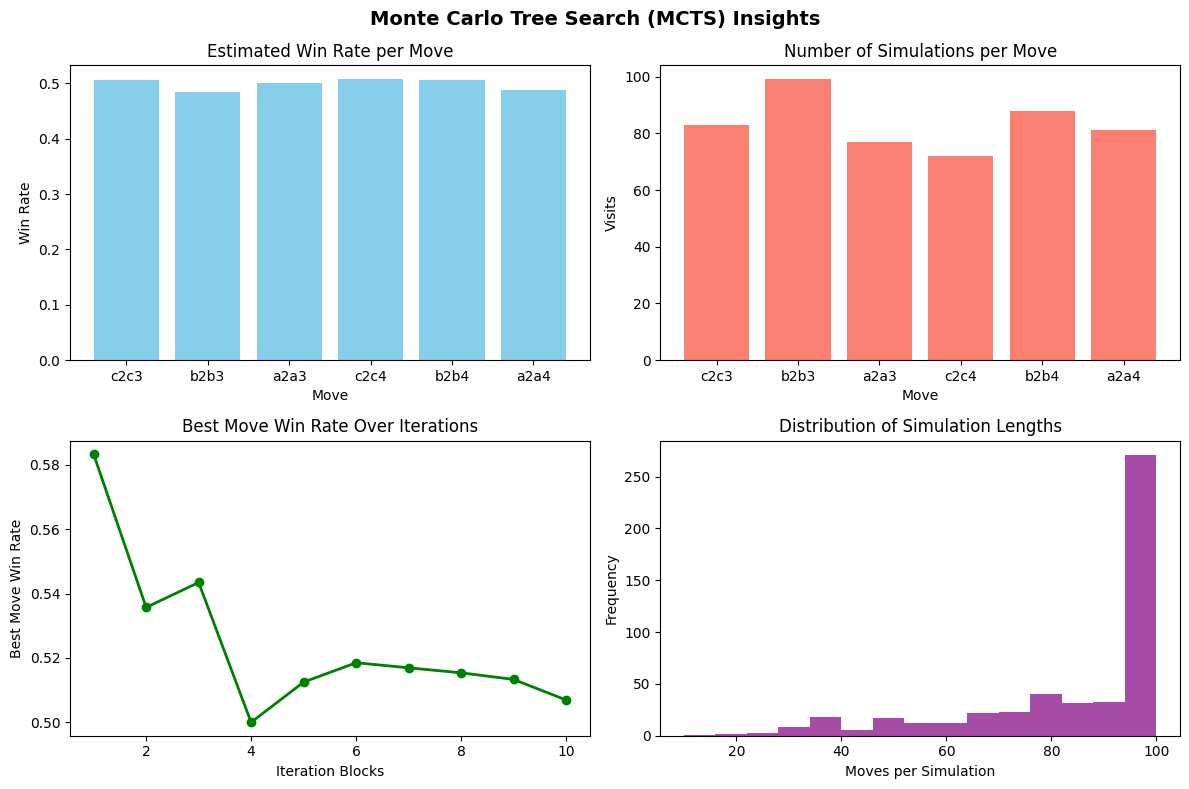

The best move is: c2c4, with score: 0.5069444374035496
White (Computer) plays: c2c4
Current board:


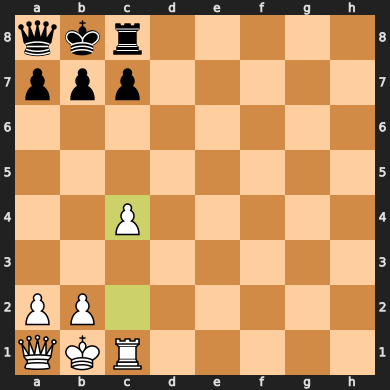

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'Quit' to quit
Legal moves: ['c7c6', 'b7b6', 'a7a6', 'c7c5', 'b7b5', 'a7a5', 'Quit']


Your move:  a7a6


Current board:


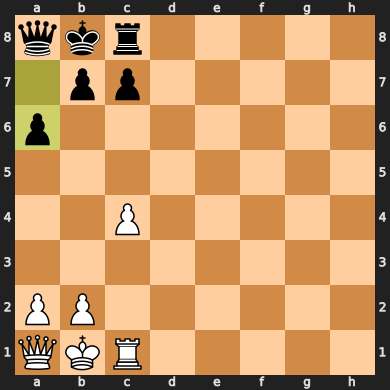

Computer (MCTS) thinking...


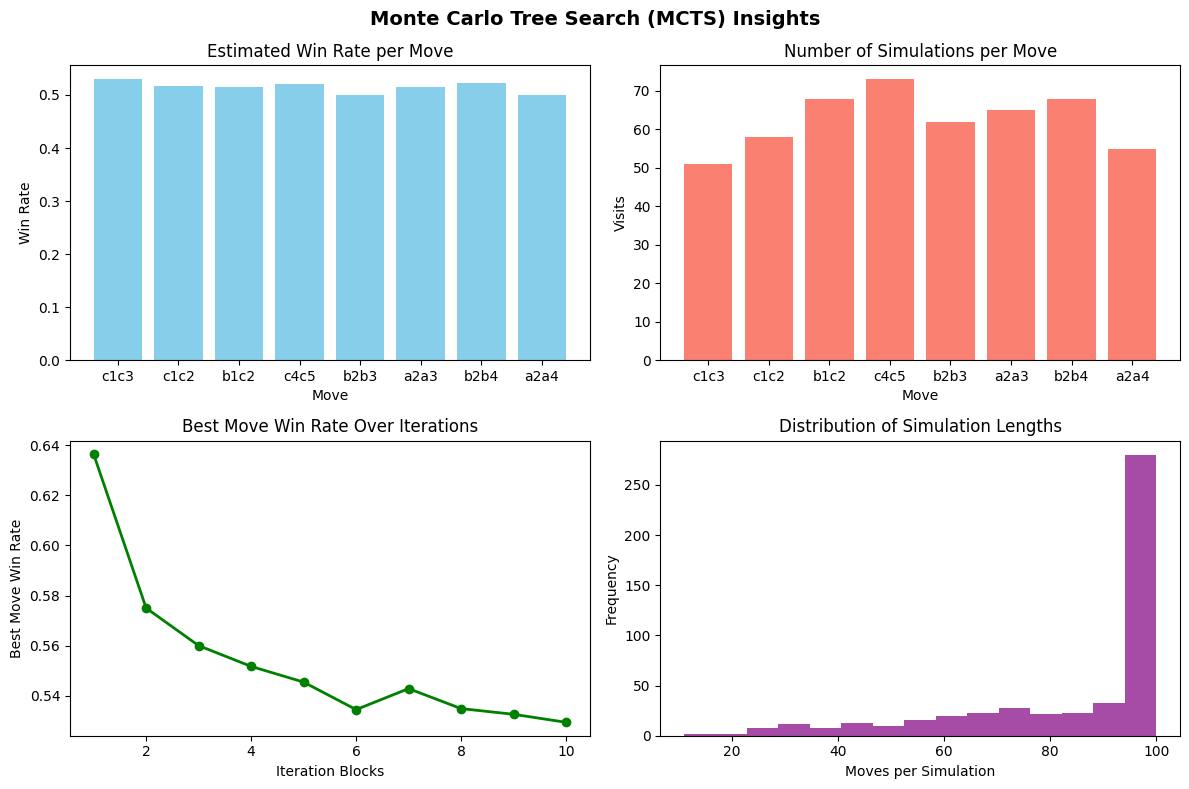

The best move is: c1c3, with score: 0.5294117543252598
White (Computer) plays: c1c3
Current board:


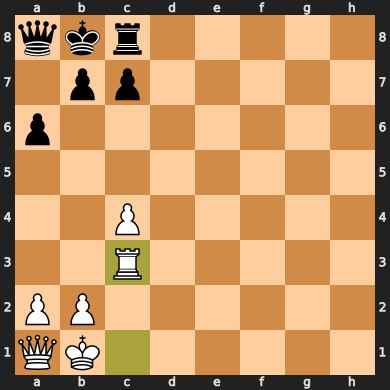

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'Quit' to quit
Legal moves: ['b8a7', 'a8a7', 'c7c6', 'b7b6', 'a6a5', 'c7c5', 'b7b5', 'Quit']


Your move:  a6a5


Current board:


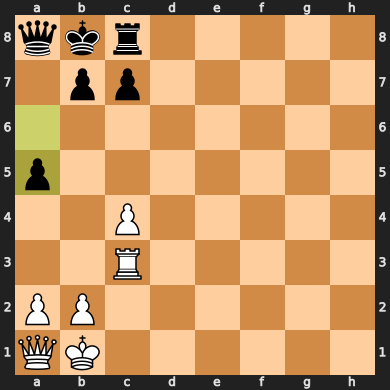

Computer (MCTS) thinking...


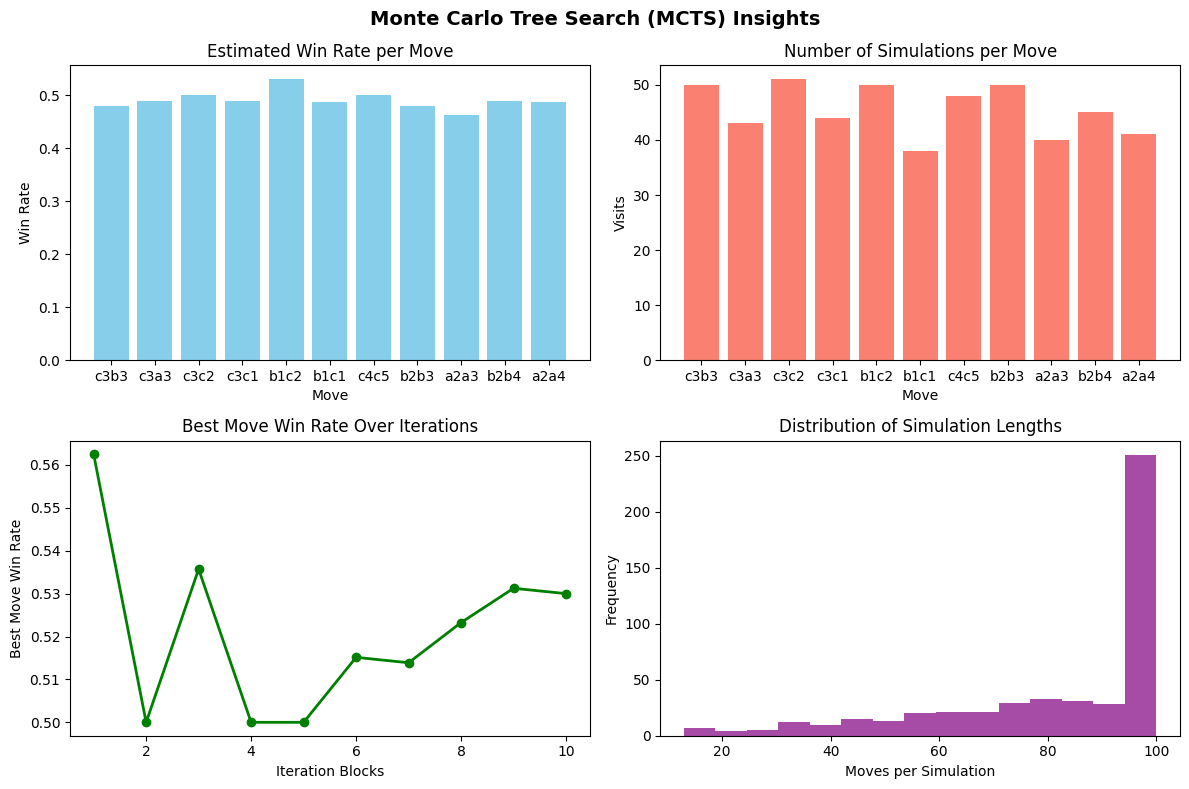

The best move is: b1c2, with score: 0.5299999894000003
White (Computer) plays: b1c2
Current board:


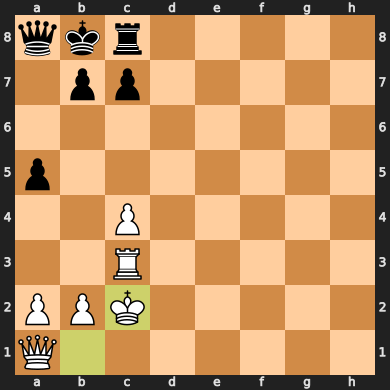

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'Quit' to quit
Legal moves: ['b8a7', 'a8a7', 'a8a6', 'c7c6', 'b7b6', 'a5a4', 'c7c5', 'b7b5', 'Quit']


Your move:  a8a6


Current board:


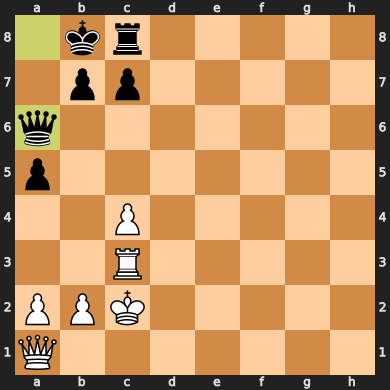

Computer (MCTS) thinking...


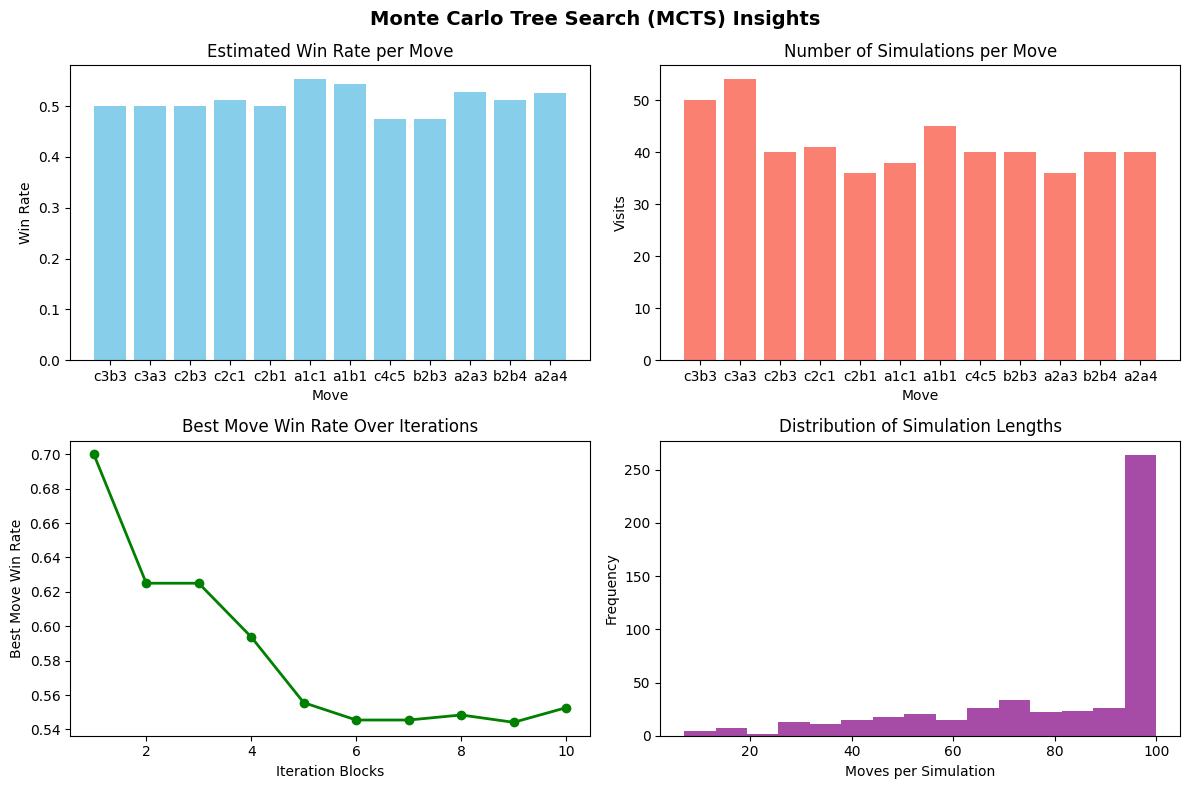

The best move is: a1c1, with score: 0.5526315644044325
White (Computer) plays: a1c1
Current board:


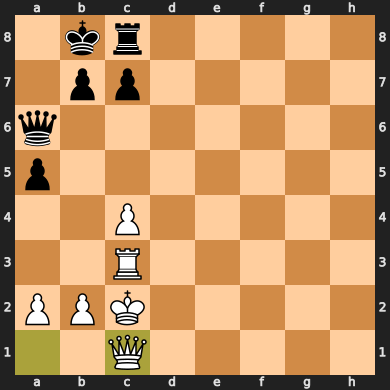

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'Quit' to quit
Legal moves: ['b8a8', 'b8a7', 'a6a8', 'a6a7', 'a6c6', 'a6b6', 'a6b5', 'a6c4', 'c7c6', 'b7b6', 'a5a4', 'c7c5', 'b7b5', 'Quit']


Your move:  a6c4


Current board:


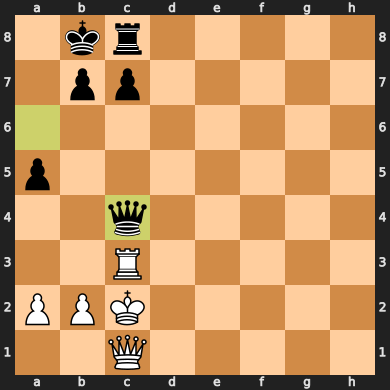

Computer (MCTS) thinking...


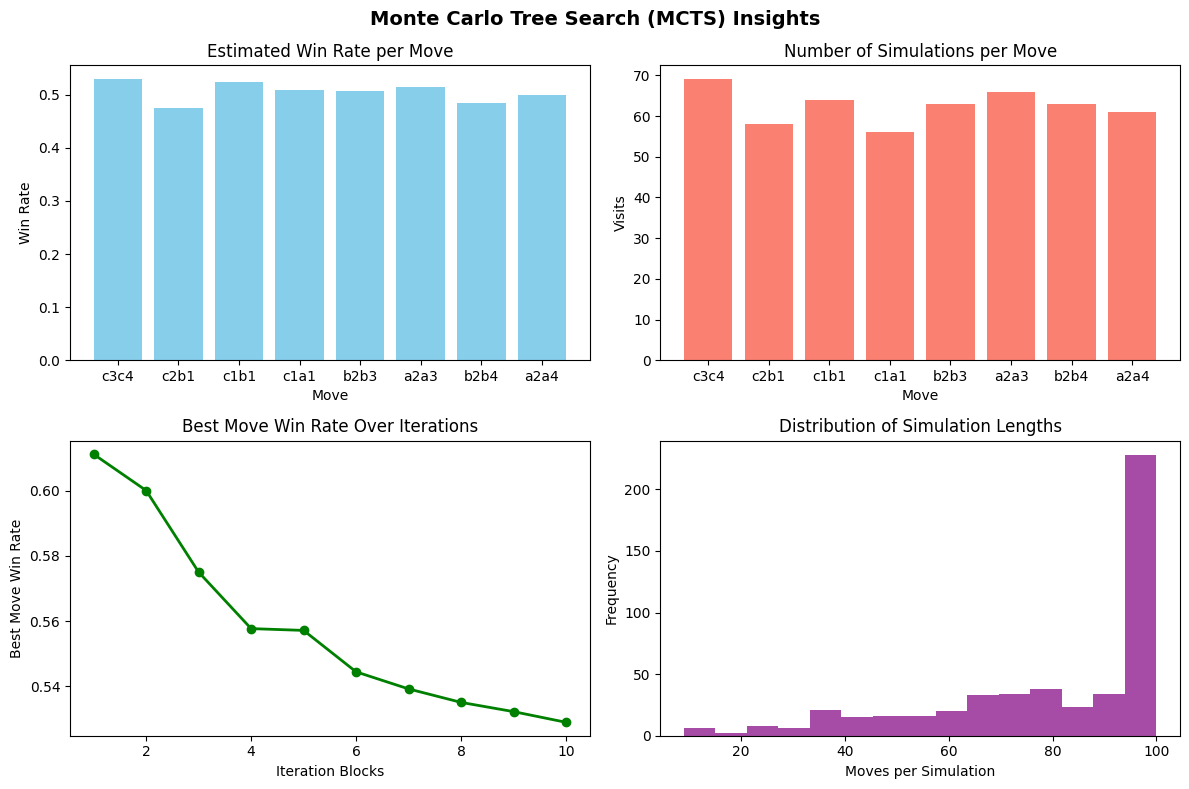

The best move is: c3c4, with score: 0.5289854995799204
White (Computer) plays: c3c4
Current board:


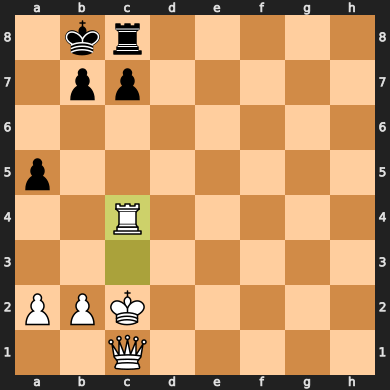

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'Quit' to quit
Legal moves: ['b8a8', 'b8a7', 'c7c6', 'b7b6', 'a5a4', 'c7c5', 'b7b5', 'Quit']


Your move:  quit


Quitting the game.

Final board:


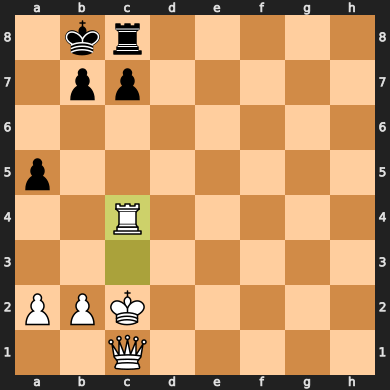

Game result: *


In [11]:
mcts_thinking_times = []
human_thinking_times = []

while not board.is_game_over():
    print("Current board:")
    display(board)

    if board.turn == chess.WHITE:
        s = datetime.now()
        print("Computer (MCTS) thinking...")
        move = mcts_move(board, 500)
        if move is None:
            print("White has no legal moves. Game over.")
            break
        e = datetime.now()
        mcts_thinking_times.append(e-s)
        print(f"White (Computer) plays: {move.uci()}")
        board.push(move)
    else:
        s = datetime.now()
        legal_moves = [m for m in board.legal_moves if is_valid_move(m)]
        if not legal_moves:
            print("Black has no legal moves. Game over.")
            break

        print("Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'Quit' to quit")
        print("Legal moves:", [m.uci() for m in legal_moves]+['Quit'])
        user_input = input("Your move: ").strip().lower()
        if user_input == "quit":
            print("Quitting the game.")
            break

        try:
            move = chess.Move.from_uci(user_input)
            if move in legal_moves:
                board.push(move)
            else:
                print("Invalid move. Try again.\n")
                continue
        except ValueError:
            print("Invalid move format. Try again.\n")
            continue
        e = datetime.now()

        human_thinking_times.append(e-s)

print("\nFinal board:")
display(board)
print("Game result:", board.result())


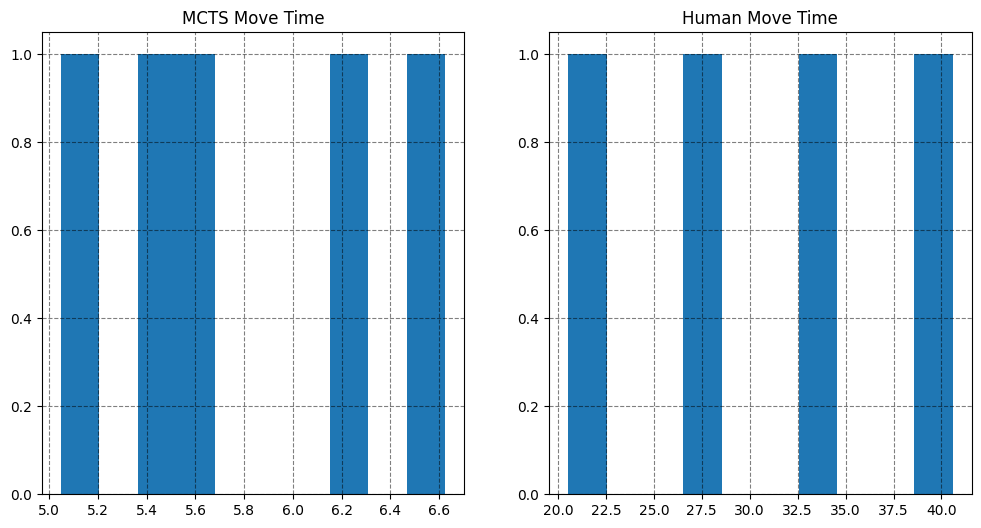

In [12]:
# -- Plot timing
fig, ax = plt.subplots(1, 2, figsize=(12,6))

thinking_times_seconds = [td.total_seconds() for td in mcts_thinking_times]
ax[0].hist(thinking_times_seconds)
ax[0].set_title(f"MCTS Move Time")
ax[0].grid(alpha=0.5, color = 'k', linestyle='--')
ax[0].set_ylabel("Freq")

thinking_times_seconds= [td.total_seconds() for td in human_thinking_times]
ax[1].hist(thinking_times_seconds)
ax[1].set_title(f"Human Move Time")
ax[1].grid(alpha=0.5, color = 'k', linestyle='--')
ax[1].set_ylabel("Freq")


plt.show()